In [58]:
import pandas as pd
import datetime as dt

dataset = pd.read_csv('./data/BTC-Daily.csv')

# convert column date of dataset to datetime
dataset['date'] = pd.to_datetime(dataset['date'])

# filter dataset to get data from 2015-01-01 to 2016-12-31
dataset = dataset[(dataset['date'] >= dt.datetime(2017, 1, 1)) & (dataset['date'] <= dt.datetime(2021, 12, 31))]

# describe dataset
dataset.describe()

,unix,open,high,low,close,Volume BTC,Volume USD
count,1.826000e+03,1826.000000,1826.000000,1826.000000,1826.000000,1.826000e+03,1.826000e+03
mean,1.562069e+09,15453.913724,15919.084754,14920.616468,15478.607913,1.785333e+07,8.568743e+07
std,4.555571e+07,16982.743115,17474.097905,16394.659506,16994.949024,5.618278e+07,1.201706e+08
min,1.483229e+09,778.700000,823.450000,751.340000,788.810000,6.927059e+02,1.144750e+03
25%,1.522649e+09,5506.175000,5645.367500,5276.032500,5512.382500,4.305773e+03,1.317266e+07
50%,1.562069e+09,8629.690000,8836.715000,8316.505000,8632.110000,7.965413e+03,5.078964e+07
75%,1.601489e+09,13859.860000,14446.050000,13082.480000,13903.460000,2.381887e+04,1.083277e+08
max,1.640909e+09,67547.490000,69000.000000,66250.000000,67559.000000,7.723295e+08,1.446125e+09


In [59]:
import numpy as np

# preserve only open, high, low, close, volume usd columns
dataset = dataset[['open', 'high', 'low', 'close', 'Volume USD']]
dataset.describe()

,open,high,low,close,Volume USD
count,1826.000000,1826.000000,1826.000000,1826.000000,1.826000e+03
mean,15453.913724,15919.084754,14920.616468,15478.607913,8.568743e+07
std,16982.743115,17474.097905,16394.659506,16994.949024,1.201706e+08
min,778.700000,823.450000,751.340000,788.810000,1.144750e+03
25%,5506.175000,5645.367500,5276.032500,5512.382500,1.317266e+07
50%,8629.690000,8836.715000,8316.505000,8632.110000,5.078964e+07
75%,13859.860000,14446.050000,13082.480000,13903.460000,1.083277e+08
max,67547.490000,69000.000000,66250.000000,67559.000000,1.446125e+09


In [60]:
# predict the price n days in the future
n = 1

In [61]:
# extract close column
close = dataset['close'].copy().to_numpy()[n:]

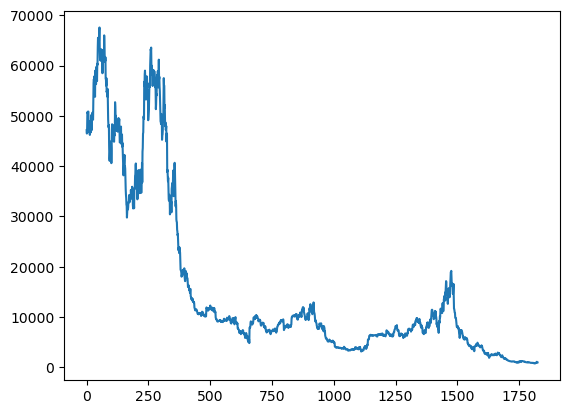

In [62]:
# plot close
import matplotlib.pyplot as plt
plt.plot(close)

In [122]:
from river import drift

# create drift detector
m_adwin = drift.ADWIN(
    delta=0.01,
    clock=1,
    min_window_length=3,
    grace_period=1
)

hddm_a = drift.HDDM_A(
    drift_confidence=0.1,
    warning_confidence=0.5,
    two_sided_test=True
)

page_hinkley = drift.PageHinkley(
)

detector = m_adwin

drifts = []

for i, val in enumerate(close):
    detector.update(val)
    if detector.drift_detected:
        drifts.append(i)

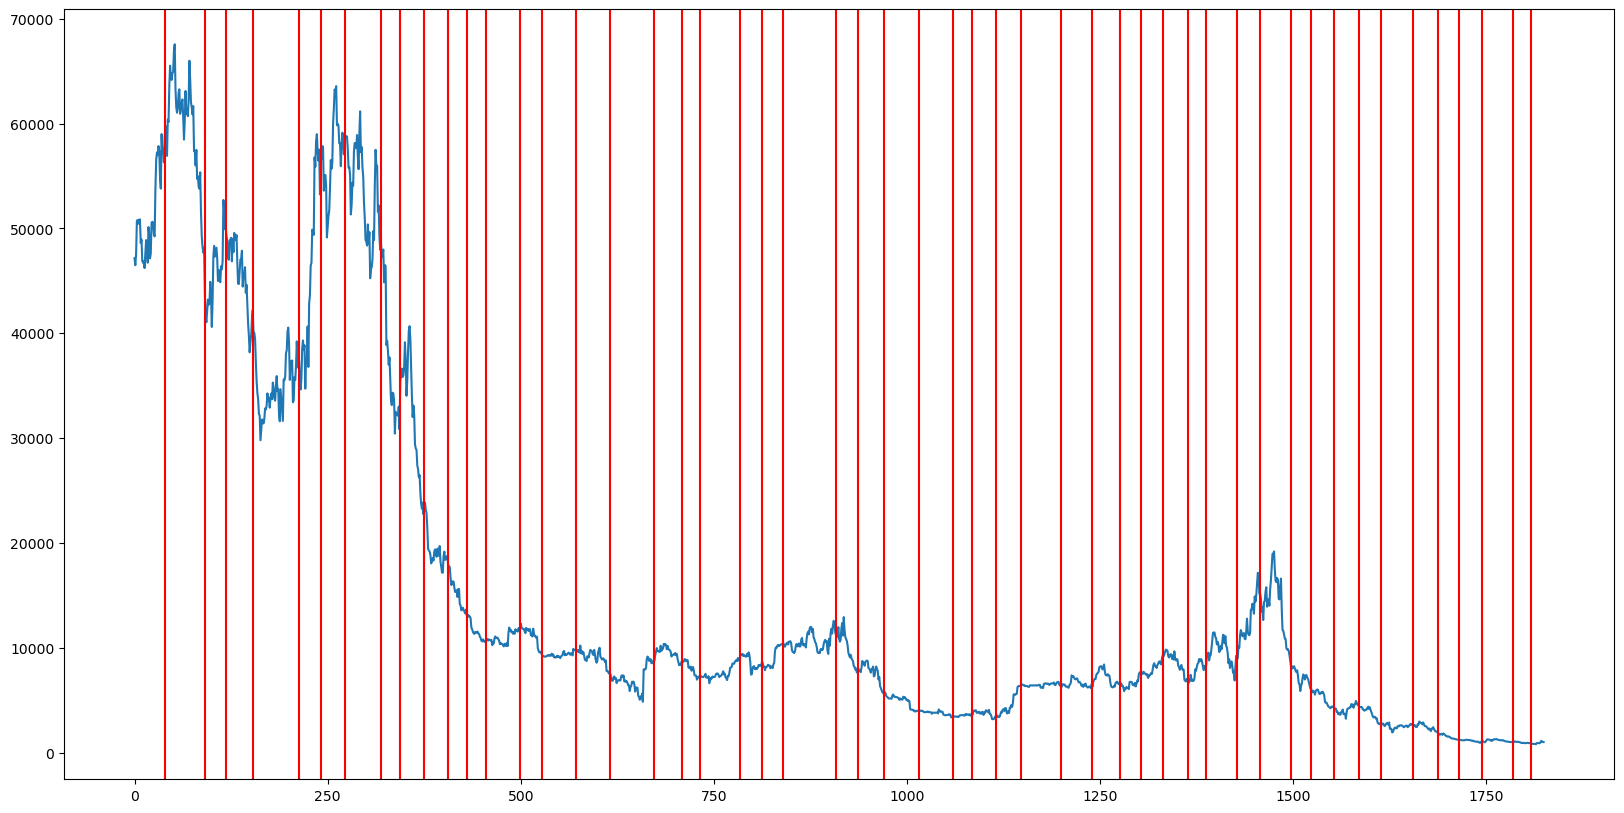

In [123]:
import matplotlib.pyplot as plt

# plot close and vertical lines for drifts, fill the width of the screen
plt.figure(figsize=(20, 10))
plt.plot(close)
for drift in drifts:
    plt.axvline(x=drift, color='r')

In [88]:
# Simulate an investment strategy
# If the prediction is higher than the current price, buy
# If the prediction is lower than the current price, sell

class investment_plan:
    def __init__(self, invested_amount, fee, percent_to_invest):
        self.invested_amount = invested_amount
        self.fee = fee
        self.percent_to_invest = percent_to_invest
        self.investment_history = []
        self.balance_history = [invested_amount]

    def invest(self, close_today, close_tomorrow_pred, close_tomorrow_true):
        percent_movement = (close_tomorrow_true - close_today) / close_today
        amount_invested = self.percent_to_invest * self.invested_amount

        if close_tomorrow_pred > close_today + amount_invested * self.fee:
            self.invested_amount += (percent_movement - self.fee) * amount_invested
            self.investment_history.append('long')
        elif close_tomorrow_pred < close_today - amount_invested * self.fee:
            self.invested_amount += (-percent_movement - self.fee) * amount_invested
            self.investment_history.append('short')
        else:
            self.investment_history.append('no_movement')

        self.balance_history.append(self.balance())

    def balance(self):
        return self.invested_amount

MAE: 1,466.2947


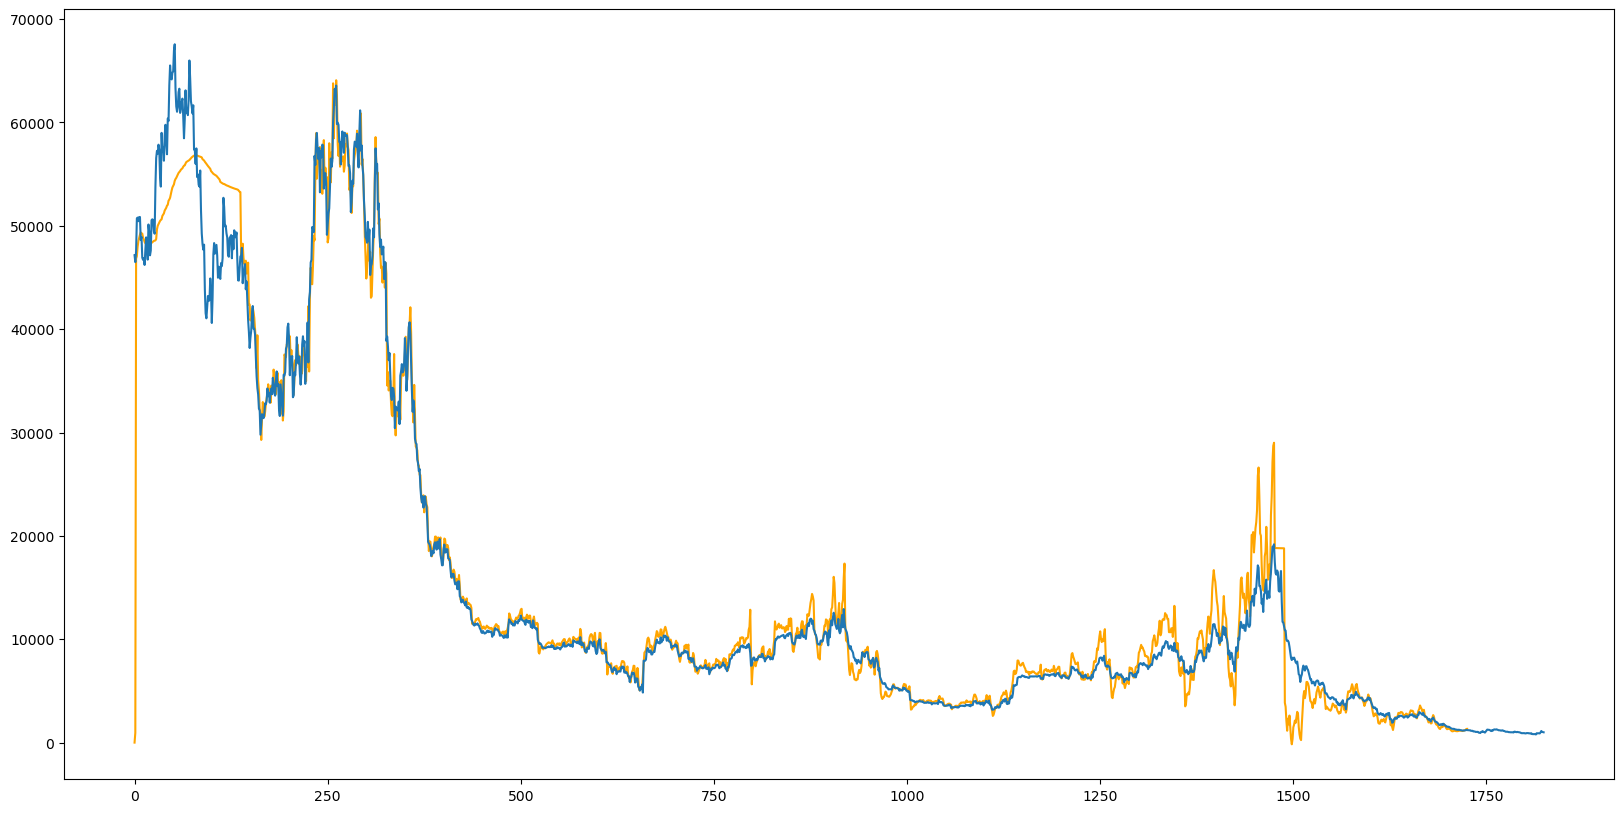

In [93]:
from river import tree
from river import evaluate
from river import metrics
from river import preprocessing

ip = investment_plan(100, 0.00, 0.05)

# create decision tree regressor
model = preprocessing.StandardScaler() | tree.HoeffdingAdaptiveTreeRegressor(
    drift_detector=m_adwin
)


samples = { i: dataset.to_numpy()[:-n][i] for i in range(len(dataset) - n) }

stream = [(dict(enumerate(samples[i])), close[i]) for i in range(len(dataset) - n)]

metric = metrics.MAE()

predictions = []


for x, y in stream:
    y_pred = model.predict_one(x)
    ip.invest(x[3], y_pred, y)
    predictions.append(y_pred)
    model.learn_one(x, y)
    metric = metric.update(y, y_pred)

print(metric)

plt.figure(figsize=(20, 10))
plt.plot(np.array(predictions), color='orange')
plt.plot(close)

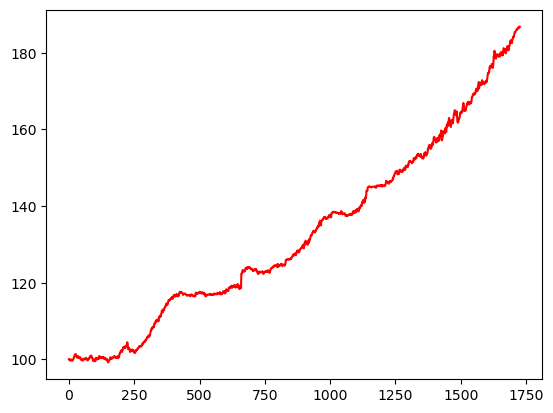

In [94]:
plt.plot(ip.balance_history, color='red')

59.61861644469374
MAE: 805.187183


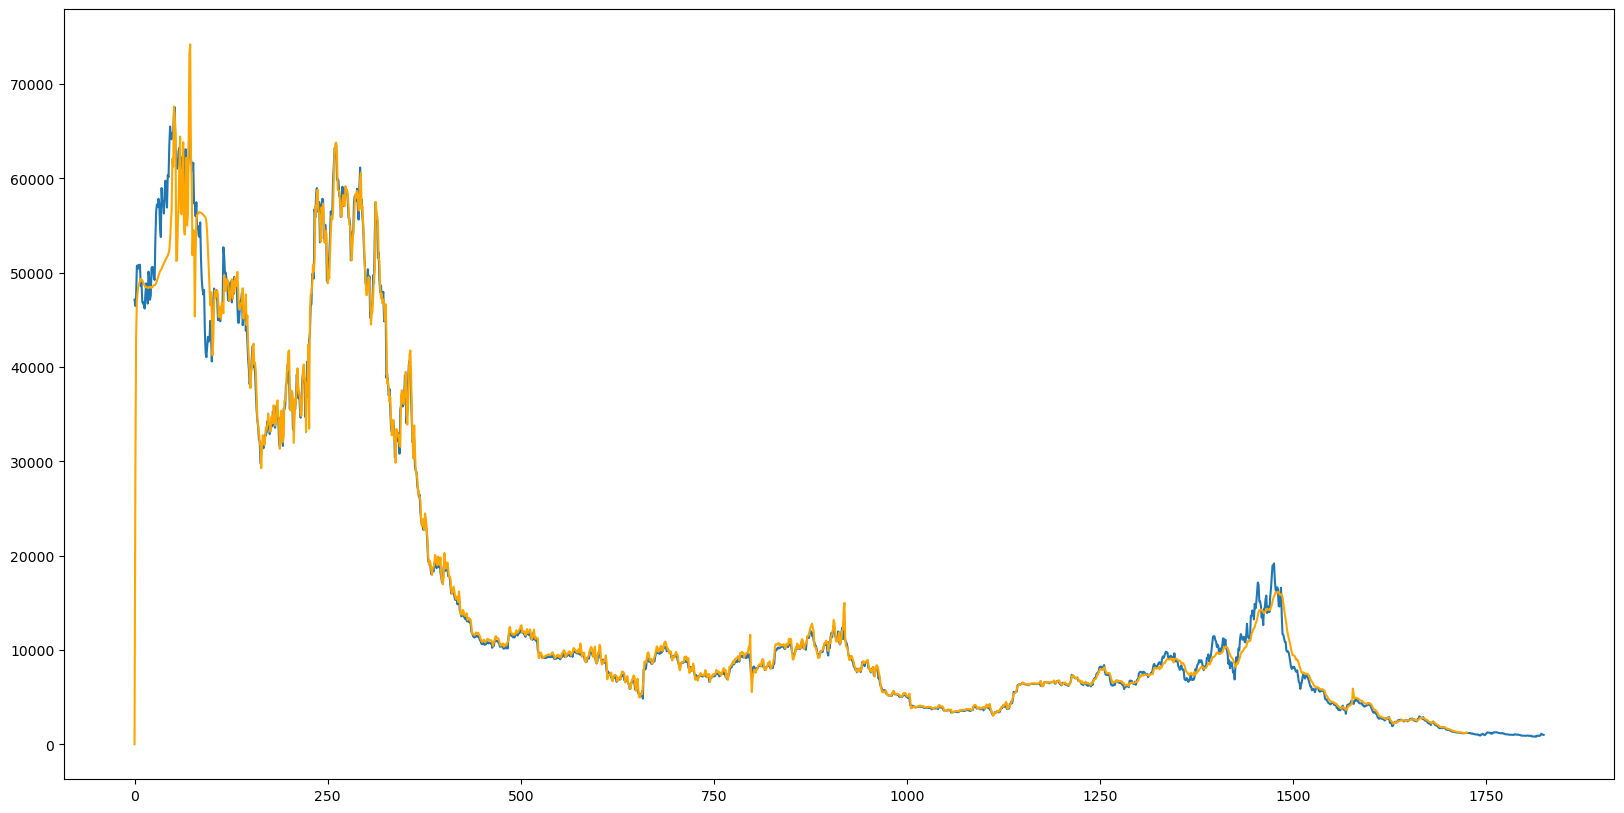

In [118]:
ip = investment_plan(invested_amount=100, fee=0.01, percent_to_invest=0.1)

from river import drift

# generate n concept drift detectors
n = 100

adwins = [
    drift.ADWIN(
        delta=0.05,
        clock=1,
        min_window_length=i+3
    ) for i in range(n)
]

# generate n decision tree regressors
models = [
    preprocessing.StandardScaler() | tree.HoeffdingAdaptiveTreeRegressor(
        drift_detector=detector.clone()
    ) for i in range(n)
]

class random_forest:
    def __init__(self, models):
        self.models = models

    def learn_one(self, x, y):
        idxs = np.random.choice(len(self.models), int(np.floor(2 * len(self.models))))
        for idx in idxs:
            self.models[idx].learn_one(x, y)

    def predict_one(self, x):
        return np.mean(np.array([self.models[i].predict_one(x) for i in range(len(self.models))]))

rf = random_forest(models)

predictions = []

metric = metrics.MAE()

for x, y in stream:
    y_pred = rf.predict_one(x)
    ip.invest(x[3], y_pred, y)
    predictions.append(y_pred)
    rf.learn_one(x, y)
    metric = metric.update(y, y_pred)

print(ip.balance())

print(metric)

plt.figure(figsize=(20, 10))
plt.plot(close)
plt.plot(predictions, color='orange')
plt.show()

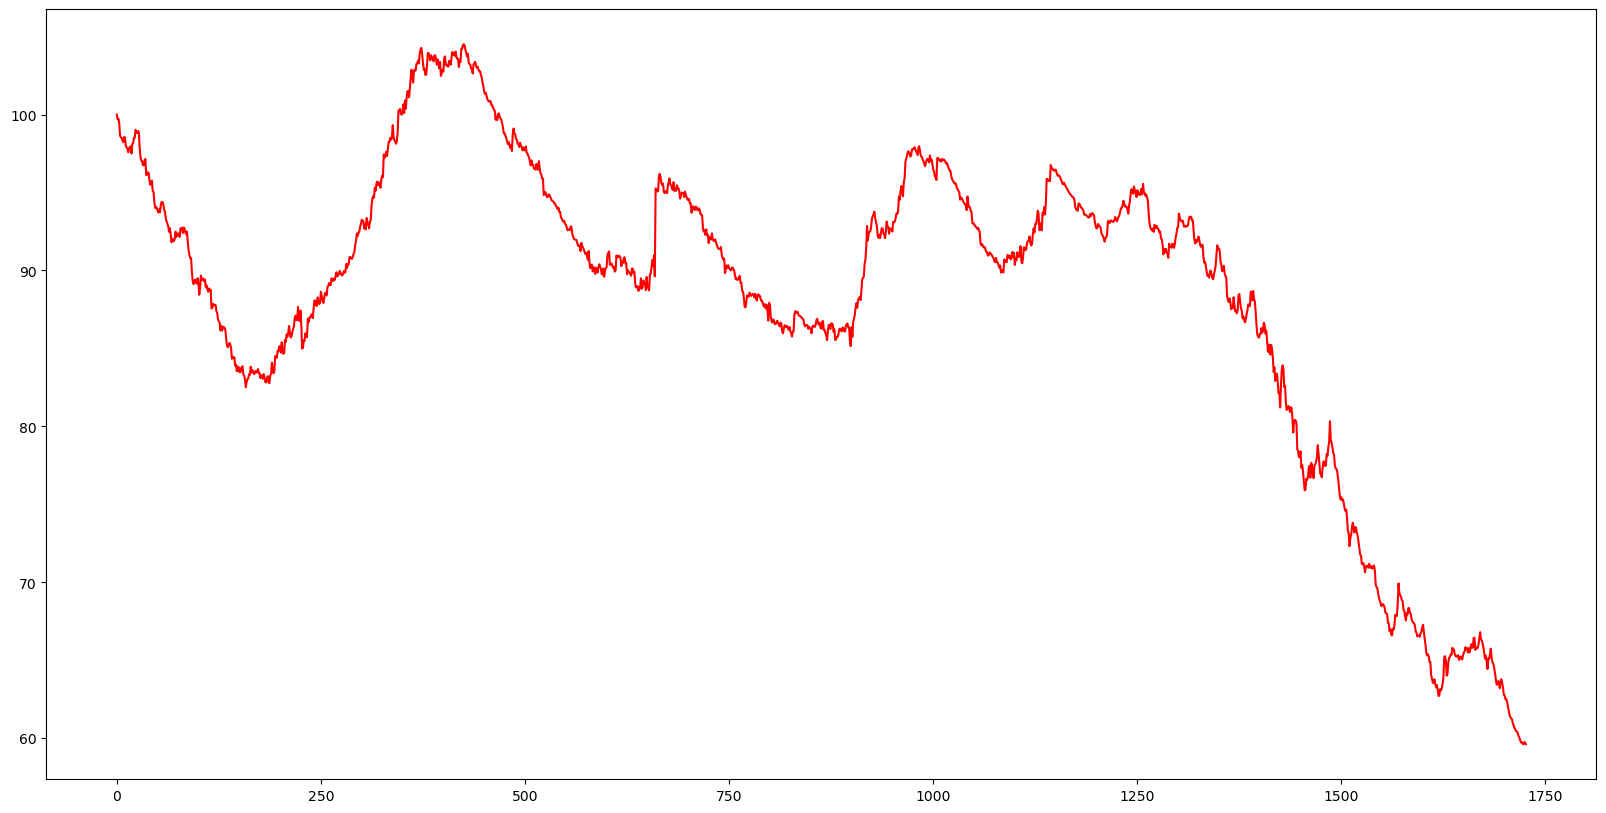

In [119]:
plt.figure(figsize=(20,10))
plt.plot(ip.balance_history, color='red')

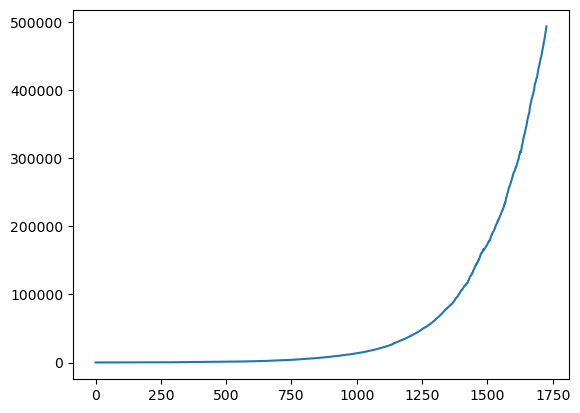

In [117]:
ip = investment_plan(100, -0.1, 0.05)

for x, y in stream:
    ip.invest(x[3], x[3] + ((x[1] - x[2]) / x[2]) * np.random.randn(1)[0], y)

plt.plot(ip.balance_history)